# Specific Task 2j. Semi-supervised Symmetry Discovery

In [1]:
#@title Imports
import torch
import random

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
from torchsummary import summary

from tqdm import tqdm

In [2]:
#@title Set random seed

# For reproducibility, taken from Neuromatch Academy's Deep Learning course material
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

set_seed(seed=42)
gen = torch.Generator().manual_seed(42)

Random seed 42 has been set.


## Dataset Preparation

Only digits 1 and 2 will be used in order to reduce computational cost.

In [3]:
#@title Load and Filter MNIST
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Filter digits
idx = torch.isin(mnist.targets, torch.tensor([1, 2]))
mnist.data = mnist.data[idx]
mnist.targets = mnist.targets[idx]

mnist.targets.shape

100%|██████████| 9.91M/9.91M [00:10<00:00, 908kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.69MB/s]


torch.Size([12700])

We rotate each sample in steps of 30 degrees

In [4]:
# Generate rotated versions for each image
rotated_images = []
rotated_labels = []

for img, label in zip(mnist.data, mnist.targets):
    # Convert tensor to PIL Image (add channel dimension for ToPILImage)
    img_pil = transforms.ToPILImage()(img.unsqueeze(0))  # Add channel dim

    # Create 12 rotations (0°, 30°, 60°, ..., 330°)
    for angle in range(0, 360, 30):
        rotated_pil = transforms.functional.rotate(img_pil, angle, expand=False)
        rotated_tensor = transforms.ToTensor()(rotated_pil)  # Shape: [1, 28, 28]
        rotated_images.append(rotated_tensor)
        rotated_labels.append(label)

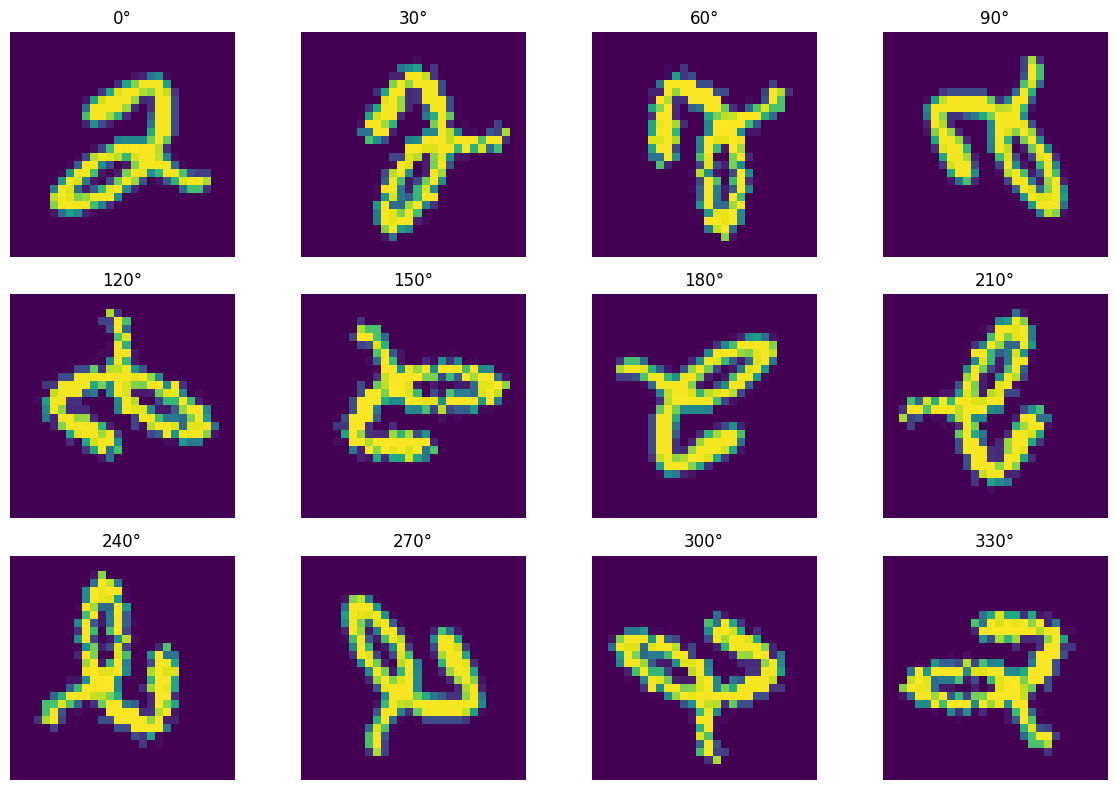

In [5]:
sample_id = 1

plt.figure(figsize=(12, 8))
for i, angle in enumerate(range(0, 360, 30)):
    plt.subplot(3, 4, i+1)
    img = rotated_images[sample_id * 12 + i][0].squeeze().numpy()
    plt.imshow(img)
    plt.title(f"{angle}°")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Combine all rotated images and labels
rotated_images_tensor = torch.stack(rotated_images)  # Shape: [N, 1, 28, 28]
rotated_labels_tensor = torch.tensor(rotated_labels, dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(rotated_images_tensor, rotated_labels_tensor)

## Latent Space Creation

Same as in [this paper](https://arxiv.org/pdf/2302.00806), I will be using $l=2$ latent dimension with two categories.

In [7]:
#@title Variational Autoencoder model architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 2*latent_dim)
            )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

In [8]:
#@title Initialize the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2
lr=1e-3
batch_size=128

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
           Flatten-5                 [-1, 3136]               0
            Linear-6                  [-1, 128]         401,536
              ReLU-7                  [-1, 128]               0
            Linear-8                    [-1, 4]             516
            Linear-9                  [-1, 128]             384
             ReLU-10                  [-1, 128]               0
           Linear-11                 [-1, 3136]         404,544
             ReLU-12                 [-1, 3136]               0
        Unflatten-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 32,

### Training VAE

In [9]:
epochs = 40
for epoch in range(epochs):
    total_loss = 0
    for x, _ in data_loader:
        x = x.to(device)
        x_recon, mu, logvar = vae(x)

        # Reconstruction loss (BCE) + KL divergence
        recon_loss = torch.nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(data_loader.dataset):.4f}")

torch.save(vae.state_dict(), "vae.pth")

Epoch 1, Average Loss: 160.3292
Epoch 2, Average Loss: 138.4753
Epoch 3, Average Loss: 134.1416
Epoch 4, Average Loss: 131.8116
Epoch 5, Average Loss: 130.4569
Epoch 6, Average Loss: 129.4086
Epoch 7, Average Loss: 128.5265
Epoch 8, Average Loss: 127.8347
Epoch 9, Average Loss: 127.3648
Epoch 10, Average Loss: 126.8670
Epoch 11, Average Loss: 126.6790
Epoch 12, Average Loss: 126.2909
Epoch 13, Average Loss: 125.8793
Epoch 14, Average Loss: 125.6403
Epoch 15, Average Loss: 125.3799
Epoch 16, Average Loss: 125.0665
Epoch 17, Average Loss: 124.8732
Epoch 18, Average Loss: 124.6735
Epoch 19, Average Loss: 124.5127
Epoch 20, Average Loss: 124.3916
Epoch 21, Average Loss: 124.2031
Epoch 22, Average Loss: 124.0405
Epoch 23, Average Loss: 123.9067
Epoch 24, Average Loss: 123.9397
Epoch 25, Average Loss: 123.6684
Epoch 26, Average Loss: 123.4718
Epoch 27, Average Loss: 123.4416
Epoch 28, Average Loss: 123.2349
Epoch 29, Average Loss: 123.1114
Epoch 30, Average Loss: 123.0521
Epoch 31, Average L

### Visualization

Original


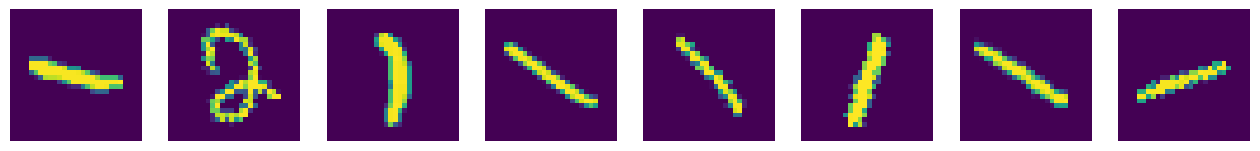

Reconstructed


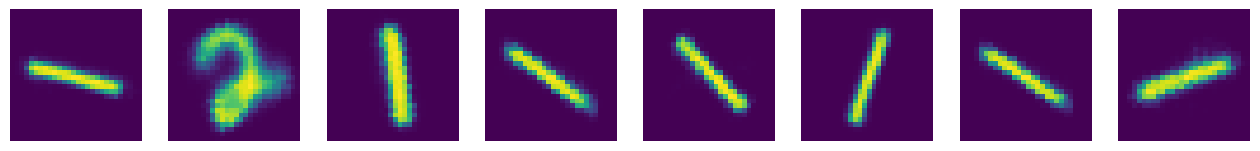

In [10]:
def plot_images(tensor, num_images):
    images = tensor.detach().numpy().transpose(0, 2, 3, 1)
    images = np.clip(images, 0, 1)

    plt.figure(figsize=(num_images*2, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].squeeze())
        plt.axis('off')
    plt.show()

x, _ = next(iter(data_loader))
x_recon, _, _ = vae(x.to(device))

print("Original")
plot_images(x.cpu(), 8)

print("Reconstructed")
plot_images(x_recon.cpu(), 8)

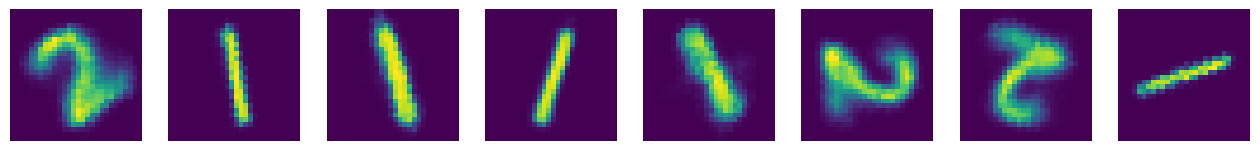

In [11]:
# Generate random images
num_samples = 8

z = torch.randn(num_samples, latent_dim).to(device)
generated_images = vae.decode(z).cpu()

plot_images(generated_images, num_samples)

# Supervised Symmetry discovery

### Dataset preparation

We create a latent space dataset where the latent vector of each sample $x$ is paired with the latent vector of its 30$^{\circ}$ rotated sample $x'$.

In [ ]:
vae.eval()
loader = DataLoader(dataset, batch_size=128, shuffle=False)
zs = []
with torch.no_grad():
    for images, _ in loader:
        images = images.to(device)
        mu, log_var = vae.encode(images)
        z = vae.reparameterize(mu, log_var)
        zs.append(z.cpu())

latent_vectors = torch.cat(zs, dim=0)
latent_vectors.shape

torch.Size([152400, 2])

In [ ]:
# Create rotation pairs (current state -> next rotation)
pairs = []
num_samples = latent_vectors.shape[0]
for i in range(0, num_samples, 12):
    group = latent_vectors[i:i+12]
    for j in range(12):
        src = group[j]
        tgt = group[(j+1)%12]
        pairs.append((src, tgt))

In [ ]:
# Dataset and DataLoader for pairs
class RotationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]

rot_ds = RotationDataset(pairs)

In [ ]:
train_dataset, test_dataset = random_split(rot_ds, [0.8, 0.2], generator=gen)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### MLP Architecture

In [ ]:
# Rotation MLP model
class MLP(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

mlp = MLP(latent_dim).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
criterion = nn.MSELoss()
summary(mlp, (1, latent_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]             768
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                 [-1, 1, 2]             258
Total params: 33,922
Trainable params: 33,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.13
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


### Training MLP

In [ ]:
# Training loop
for epoch in range(25):
    mlp.train()
    total_loss = 0
    for src, tgt in train_loader:
        src = src.to(device)
        tgt = tgt.to(device)

        optimizer.zero_grad()
        pred = mlp(src)
        loss = criterion(pred, tgt)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * src.size(0)

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 20.1847
Epoch 2, Loss: 14.0294
Epoch 3, Loss: 13.2300
Epoch 4, Loss: 12.8437
Epoch 5, Loss: 12.5180
Epoch 6, Loss: 12.3794
Epoch 7, Loss: 12.2174
Epoch 8, Loss: 12.1367
Epoch 9, Loss: 12.1075
Epoch 10, Loss: 12.0300
Epoch 11, Loss: 11.9380
Epoch 12, Loss: 11.8886
Epoch 13, Loss: 11.8323
Epoch 14, Loss: 11.8185
Epoch 15, Loss: 11.7539
Epoch 16, Loss: 11.7344
Epoch 17, Loss: 11.7558
Epoch 18, Loss: 11.6879
Epoch 19, Loss: 11.6976
Epoch 20, Loss: 11.6666
Epoch 21, Loss: 11.6243
Epoch 22, Loss: 11.6059
Epoch 23, Loss: 11.6045
Epoch 24, Loss: 11.5822
Epoch 25, Loss: 11.5263


### Evaluation

In [ ]:
# Evaluation
mlp.eval()
test_loss = 0
with torch.no_grad():
    for src, tgt in test_loader:
        src = src.to(device)
        tgt = tgt.to(device)
        pred = mlp(src)
        test_loss += criterion(pred, tgt).item() * src.size(0)

print(f"Test Loss: {test_loss/len(test_loader):.4f}")

Test Loss: 11.9223


In [ ]:
src_images = vae.decoder(src).cpu()
tgt_images = vae.decoder(tgt).cpu()

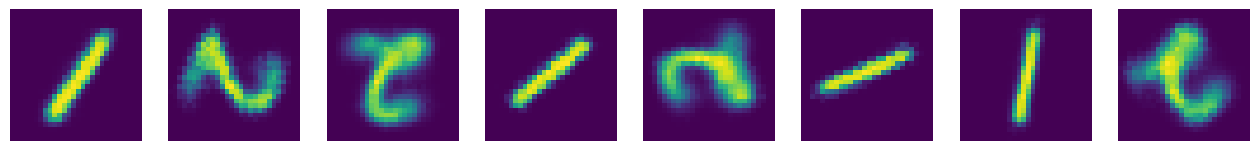

In [ ]:
plot_images(src_images, 8)

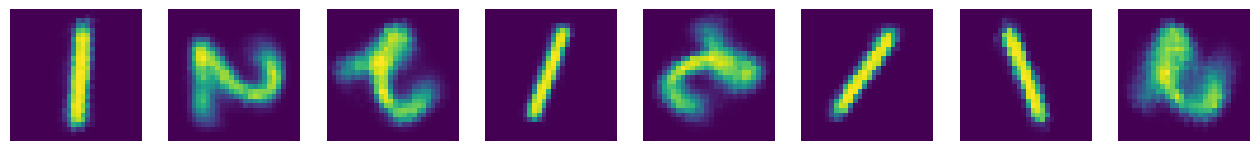

In [ ]:
plot_images(tgt_images, 8)

# Unsupervised Symmetry Discovery
$l=2$ latent dimension is used with single generator model for symmetry discovery.

In [12]:
oracle = nn.Sequential(
    nn.Linear(latent_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 2)  # Logits for classes 1 and 2
).to(device)

In [13]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=gen)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [14]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(30):
    oracle.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)-1  # Classes 0 and 1
        optimizer.zero_grad()
        with torch.no_grad():
            mu, log_var = vae.encode(images)
            z = vae.reparameterize(mu, log_var)
        logits = oracle(z)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.1162
Epoch 2, Loss: 0.0726
Epoch 3, Loss: 0.0697
Epoch 4, Loss: 0.0683
Epoch 5, Loss: 0.0670
Epoch 6, Loss: 0.0659
Epoch 7, Loss: 0.0655
Epoch 8, Loss: 0.0646
Epoch 9, Loss: 0.0641
Epoch 10, Loss: 0.0635
Epoch 11, Loss: 0.0626
Epoch 12, Loss: 0.0621
Epoch 13, Loss: 0.0617
Epoch 14, Loss: 0.0614
Epoch 15, Loss: 0.0610
Epoch 16, Loss: 0.0609
Epoch 17, Loss: 0.0606
Epoch 18, Loss: 0.0604
Epoch 19, Loss: 0.0604
Epoch 20, Loss: 0.0600
Epoch 21, Loss: 0.0603
Epoch 22, Loss: 0.0600
Epoch 23, Loss: 0.0601
Epoch 24, Loss: 0.0596
Epoch 25, Loss: 0.0598
Epoch 26, Loss: 0.0594
Epoch 27, Loss: 0.0593
Epoch 28, Loss: 0.0592
Epoch 29, Loss: 0.0592
Epoch 30, Loss: 0.0591


In [15]:
# Define symmetry generator network
class SymmetryGenerator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, z):
        return self.net(z)

generator = SymmetryGenerator(latent_dim).to(device)
optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
epsilon = 1e-3  # Infinitesimal step
h=1.5 # Hyperparameter for the normalization loss

for epoch in range(40):
    generator.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        # Get latent vectors
        with torch.no_grad():
            mu, log_var = vae.encode(images)
            z = vae.reparameterize(mu, log_var)

        # Generate transformation
        delta_z = generator(z)
        z_prime = z + epsilon * delta_z

        # Get logits before and after transformation
        logits_orig = oracle(z)
        logits_trans = oracle(z_prime)

        # Calculate losses
        inv_loss = F.mse_loss(logits_trans, logits_orig)/(epsilon**2)

        norm = torch.norm(delta_z, dim=1)
        norm_loss = F.mse_loss(norm, torch.ones_like(norm)) + torch.mean((norm - norm.mean())**2)

        loss = inv_loss + h*norm_loss

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')


Epoch 1, Loss: 1.0645
Epoch 2, Loss: 0.8747
Epoch 3, Loss: 0.7779
Epoch 4, Loss: 0.7230
Epoch 5, Loss: 0.6859
Epoch 6, Loss: 0.6601
Epoch 7, Loss: 0.6437
Epoch 8, Loss: 0.6314
Epoch 9, Loss: 0.6212
Epoch 10, Loss: 0.6123
Epoch 11, Loss: 0.6012
Epoch 12, Loss: 0.5925
Epoch 13, Loss: 0.5861
Epoch 14, Loss: 0.5763
Epoch 15, Loss: 0.5706
Epoch 16, Loss: 0.5634
Epoch 17, Loss: 0.5579
Epoch 18, Loss: 0.5525
Epoch 19, Loss: 0.5475
Epoch 20, Loss: 0.5436
Epoch 21, Loss: 0.5384
Epoch 22, Loss: 0.5355
Epoch 23, Loss: 0.5314
Epoch 24, Loss: 0.5289
Epoch 25, Loss: 0.5245
Epoch 26, Loss: 0.5212
Epoch 27, Loss: 0.5182
Epoch 28, Loss: 0.5160
Epoch 29, Loss: 0.5106
Epoch 30, Loss: 0.5094
Epoch 31, Loss: 0.5057
Epoch 32, Loss: 0.5024
Epoch 33, Loss: 0.5009
Epoch 34, Loss: 0.4980
Epoch 35, Loss: 0.4953
Epoch 36, Loss: 0.4932
Epoch 37, Loss: 0.4872
Epoch 38, Loss: 0.4852
Epoch 39, Loss: 0.4815
Epoch 40, Loss: 0.4800


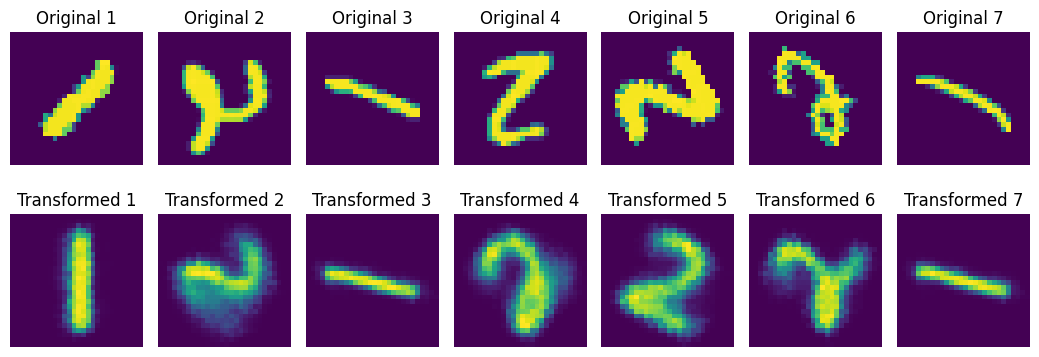

In [24]:
#@title Discovered Symmatries
def plot_original_vs_transformed(originals, transformed, num_samples=5):
    plt.figure(figsize=(1.5*num_samples, 4))

    # Plot originals in the first row
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(originals[i][0].cpu().numpy())
        plt.title(f"Original {i+1}")
        plt.axis('off')

    # Plot transformed in the second row
    for i in range(num_samples):
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(transformed[i][0].cpu().numpy())
        plt.title(f"Transformed {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get multiple samples from the dataset
num_samples = 7
sample_imgs, _ = next(iter(train_loader))
sample_imgs = sample_imgs[:num_samples].to(device)
steps = 1000
# Generate transformed versions
with torch.no_grad():
    # Encode to latent space
    mu, log_var = vae.encode(sample_imgs)
    z = vae.reparameterize(mu, log_var)
    # Apply symmetry transformation
    for _ in range(steps):  #
        z += epsilon * generator(z)
    # Decode transformed latent vectors
    transformed_imgs = vae.decode(z).cpu()
# Convert original images to CPU for plotting
original_imgs = sample_imgs.cpu()
# Plot comparison
plot_original_vs_transformed(original_imgs, transformed_imgs, num_samples)

In [25]:
test_loader = DataLoader(dataset, batch_size=128, shuffle=False)

In [26]:
# Encode images and collect latent vectors
latent_vectors, labels_list = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        mu, _ = vae.encode(images)
        latent_vectors.append(mu)
        labels_list.append(labels)

latent_vectors = torch.cat(latent_vectors).cpu().numpy()
labels = torch.cat(labels_list).cpu().numpy()

In [27]:
# Get direction outputs (delta_z) from the secondary model
latent_tensor = torch.tensor(latent_vectors, dtype=torch.float32).to(device)
with torch.no_grad():
    delta_z = generator(latent_tensor).cpu().numpy()

In [29]:
# Normalize directions for consistent arrow lengths
norms = np.linalg.norm(delta_z, axis=1, keepdims=True)
delta_z_normalized = delta_z / (norms + 1e-8)  # Avoid division by zero
scale = 0.2  # Adjust this to control arrow length
delta_z_scaled = delta_z_normalized * scale

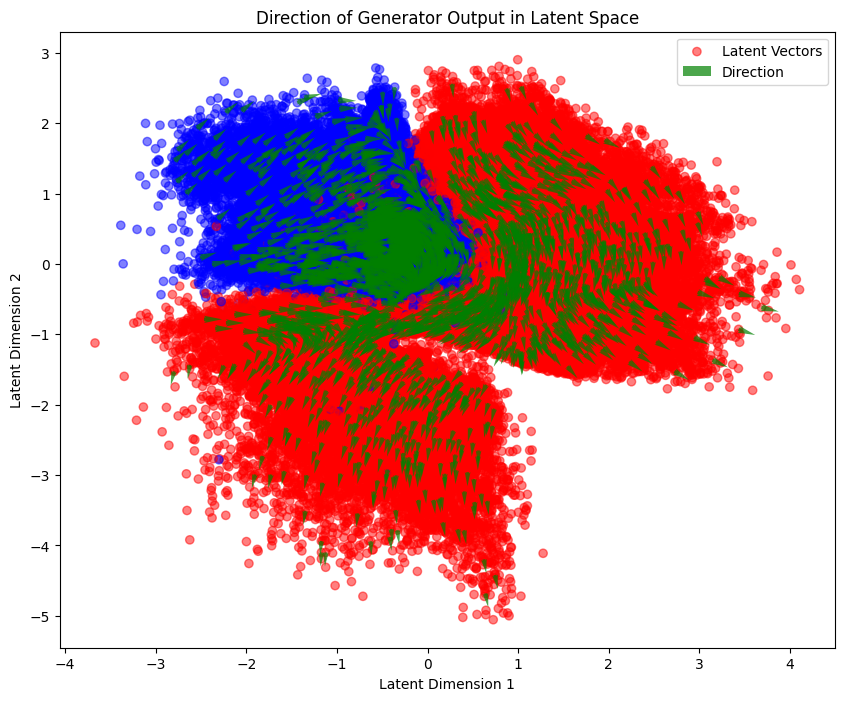

In [30]:
n_samples = len(latent_vectors)
subsample_idx = np.random.choice(n_samples, size=n_samples // 50, replace=False)  # 50% of data

# Plot
plt.figure(figsize=(10, 8))
colors = ['red' if label == 1 else 'blue' for label in labels]
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=colors, alpha=0.5, label='Latent Vectors')

# Plot arrows for direction (using normalized/scaled delta_z)
plt.quiver(
    latent_vectors[subsample_idx, 0], latent_vectors[subsample_idx, 1],
    delta_z_scaled[subsample_idx, 0], delta_z_scaled[subsample_idx, 1],
    angles='xy', scale_units='xy', scale=1,
    color='green', width=0.005, headwidth=2, alpha=0.7,
    label='Direction'
)

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Direction of Generator Output in Latent Space')
plt.legend()
plt.show()